## 0. Import Necessary Libraries

In [75]:
import glob
import os
import json
import pandas as pd
import matplotlib.pyplot as plt

## 1. Load the Data

### 1.1. Create a list of files in the folder

In [2]:
file_list = glob.glob(os.path.join(os.getcwd(), "D:/Users/suuser/Desktop/Cesitli/SICSS/data/vaccine_tweets", "*.json"))

tweet_list = [s for s in file_list if "data_" in s]
user_list  = [s for s in file_list if "users_" in s]

### 1.2. Collect all .json files

In [3]:
tweet_data = []

for file_name in tweet_list:
    with open(file_name, encoding="utf8") as json_file:
        json_file = json.load(json_file)
        for data in json_file:
            tweet_data.append(data)
            

user_data = []

for file_name in user_list:
    with open(file_name, encoding="utf8") as json_file:
        json_file = json.load(json_file)
        for data in json_file['users']:
            user_data.append(data)

### 1.3. Convert to Pandas DataFrame

In [4]:
tweet_data = pd.DataFrame(tweet_data)
user_data = pd.DataFrame(user_data)

### 1.4. Drop Unnecessary Columns

In [6]:
tweet_data.drop(columns=['entities','context_annotations', 'referenced_tweets', 'conversation_id', 'source', 'attachments', 
                         'in_reply_to_user_id', 'withheld', 'geo'], inplace=True)


user_data.drop(columns=['protected','profile_image_url','pinned_tweet_id', 'url', 'entities', 'withheld'], inplace=True)

### 1.5. Change Column Names of user_data

In [18]:
user_data.columns = ['user_' + x for x in user_data.columns]

### 1.6. Merge tweet_data & user_data

In [35]:
df = tweet_data.merge(user_data.drop_duplicates('user_id'), how='left', left_on = 'author_id', right_on = 'user_id')
df.drop(columns=['user_id'], inplace=True)

### 1.7. Convert Associated Columns to Datetime

In [73]:
df.created_at = pd.to_datetime(df.created_at)
df.user_created_at = pd.to_datetime(df.user_created_at)

### 1.8. Save Data as .csv

In [37]:
df.to_csv('D:/Users/suuser/Desktop/Cesitli/SICSS/data/df.csv')

## 2. Counting Things

### 2.1. Create Categorical Variables for Each Keyword

In [68]:
#Çin aşısı
df.loc[df.text.str.lower().str.contains('cin asi|çin aşı|çın aşı|çin aşi|cın ası|cın aşı|çın aşi|çin asi|cin aşı'), 'cin_asi'] = 1

#Sinovac
df.loc[df.text.str.lower().str.contains('sinovac|sınovac|sınovaç|sinovaç|sinovak|coronavac'), 'sinovac'] = 1

#Alman Aşısı
df.loc[df.text.str.lower().str.contains('alman asi|alman aşı|alman aşi'), 'alman_asi'] = 1

#Biontech
df.loc[df.text.str.lower().str.contains('biontech|bıontech|biontec|bıontec'), 'biontech'] = 1

#Pfizer
df.loc[df.text.str.lower().str.contains('pfizer|pfızer'), 'pfizer'] = 1

#Gavur Aşısı
df.loc[df.text.str.lower().str.contains('gavur aşı|gavur aşi|gavur asi'), 'gavur_asi'] = 1

In [110]:
df['created_month'] = df.created_at.dt.to_period('m')

<Figure size 864x432 with 0 Axes>

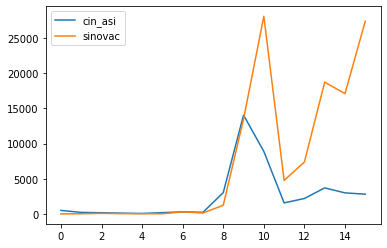

In [124]:
plt.figure(figsize=(12,6))
df.pivot_table(values=['cin_asi','sinovac'], index='created_month', aggfunc='sum').reset_index().plot()
plt.show()

<Figure size 864x432 with 0 Axes>

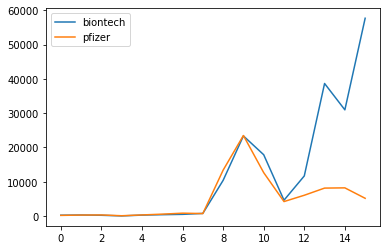

In [127]:
plt.figure(figsize=(12,6))
df.pivot_table(values=['biontech','pfizer'], index='created_month', aggfunc='sum').reset_index().plot()
plt.show()

<Figure size 864x432 with 0 Axes>

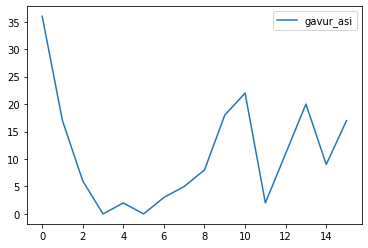

In [128]:
plt.figure(figsize=(12,6))
df.pivot_table(values=['gavur_asi'], index='created_month', aggfunc='sum').reset_index().plot()
plt.show()

## 3. Pronoun Extraction

In [130]:
from transformers import AutoModel, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-base-turkish-cased")
model = AutoModel.from_pretrained("dbmdz/bert-base-turkish-cased")

Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/251k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/445M [00:00<?, ?B/s]

In [152]:
df.text

0         Bu aşı tutarsa ... senaryo belli .\nGerisi mal...
1         @sputnik_TR Acaba Corona virüsünün hangi versi...
2         Yeni tip koronavirüse (Kovid-19) karşı ABD Kar...
3         📍ABD ordusundan "koronavirüs aşısı farelerde d...
4         @traderAT12 Pfizer, koronavirüs tedavileri pot...
                                ...                        
598093    @halukvehaluk ya hu biz biontech olduk yandan ...
598094    @mekselenya @haskologlu Sinovac ol o zaman mrn...
598095    Bu iyi haber değil 😔 Bir an önce herkesi Biont...
598096    Biontech Covid19 aşısı erkeklerde sperm sayısı...
598097    @kub_kub_kubra @DrGunerSonmez Tabiki değilim.2...
Name: text, Length: 598098, dtype: object

In [144]:
df.user_name.str

0                          Ömer ŞEN
1                         Dr.roland
2                   ÇapaMag Ekonomi
3                         EHA MEDYA
4                Mehmet Sedat Aydın
                    ...            
598093                  SerefCHElik
598094                       peníze
598095    Lone Wolf 128M 🥃🍷🎮🎬🌈 🏀 🎾🐈
598096                 Selçuk Yücel
598097                       Gülcan
Name: user_name, Length: 598098, dtype: object

In [131]:
model.

['Bu',
 'co',
 '##vi',
 '##d',
 'aşısı',
 '##nı',
 'olsam',
 'mı',
 'olmasa',
 '##m',
 'mı',
 'karar',
 'verem',
 '##edim',
 '.']